In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.externals import joblib

In [3]:
df = pd.read_csv("data/recipe_0_out_balec_small.csv", index_col=0)

In [4]:
val = pd.read_csv("data/recipe_0_val_reg.csv")

## Mean model

In [5]:
df['class'].value_counts()

above      148
optimal    146
below       70
Name: class, dtype: int64

In [6]:
df[df['class'] == 2]['steam_pres_avg'].mean()

nan

In [7]:
(df['class'] == df['class'].shift(1)).mean()

0.5082417582417582

In [8]:
np.sqrt(((df['efficiency'] - df['efficiency'].mean())**2).mean())

15.739961157802279

## Regresja liniowa

In [9]:
cols_to_fit = ['sifter_speed_nominal_pct', 'water_correction', 'steam_preasure', 'dd_speed', 'temp_out', 
               'water_pct', 'steam_pres_avg', 'steam_pres_min',
      'steam_pres_max', 'prod_temp_jetcooker_avg', 'prod_temp_jetcooker_min',
      'prod_temp_jetcooker_max', 'prod_temp_avg', 'prod_temp_min',
      'prod_temp_max', 'steam_pres_jetcooker_avg', 'steam_pres_jetcooker_min',
      'steam_pres_jetcooker_max', 'cond_temp_avg', 'cond_temp_min',
      'cond_temp_max',
              'fat_pct', 'particles_grp1', 'particles_grp2', 'particles_grp3', 'moisture', 'elems']

In [54]:
cols_to_fit = [ 'dd_speed', 'particles_grp1',
              'particles_grp2', 'particles_grp3', 'moisture', 'elems']

In [55]:
df_train = df.loc[df['id'] < 25]
df_test=  df.loc[df['id'] > 25]

In [56]:
for col in cols_to_fit:
    print(df_train[col].mean(), df_train[col].std(), df_test[col].mean(), col)

8.108503401360544 0.7753205689455359 7.781818181818182 dd_speed
0.47514858163265306 0.12686600027318523 0.5520472545454544 particles_grp1
0.26685044557823134 0.12130745020626232 0.19667089090909085 particles_grp2
0.24511571768707482 0.02858362109757475 0.23959356363636358 particles_grp3
11.170810204081633 0.5798612999080179 12.358950909090913 moisture
2.292517006802721 0.8238002703175755 2.4909090909090907 elems


In [57]:
df_train[df_train['class'] == 2]['water_correction'].mean()

-51.76229508196721

In [58]:
df_test[df_test['class'] == 2]['water_correction'].mean()

-27.391304347826086

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
import sklearn
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [60]:
rf = RandomForestRegressor(n_estimators=10, max_depth=1, min_samples_split=3,
                           min_samples_leaf=2)

In [61]:
xgb = xgboost.XGBRegressor(booster='gbtree')

In [62]:
svr = SVR(gamma="auto",kernel="linear", C=10, degree=4)

In [63]:
lr = LinearRegression()

In [64]:
df['class'] = df['class'].astype('category').cat.codes

In [65]:
xgb.fit(df_train[cols_to_fit], df_train['efficiency'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [66]:
svr.fit(df[cols_to_fit], df['class'])

SVR(C=10, cache_size=200, coef0=0.0, degree=4, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [67]:
rf = RandomForestRegressor(n_estimators=100, max_depth=5, max_features=None)

In [68]:
svr.fit(df_train[cols_to_fit], df_train['efficiency'])
rf.fit(df_train[cols_to_fit], df_train['efficiency'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [69]:
#df['preds_stack'] = (lr.predict_proba(df[cols_to_fit]) + rf.predict_proba(df[cols_to_fit])).argmax(axis=1)
df['preds'] =  2*(svr.predict(df[cols_to_fit])) / 2

In [70]:
df['class'] = df_test['class'].astype('category').cat.codes

In [71]:
df['class_preds'] = np.where(df['preds'] < 98, 0, np.where(df['preds'] > 110, 2, 1))
df['class'] = np.where(df['efficiency'] < 98, 0, np.where(df['efficiency'] > 110, 2, 1))

In [72]:
df_train = df.loc[df['id'] < 25]
df_test=  df.loc[df['id'] > 25]

In [73]:
(df_test['class'] == df_test['class_preds']).mean()

0.4727272727272727

In [74]:
val['efficiency'] = svr.predict(val[cols_to_fit])

In [75]:
val.to_csv("efficiency_val_receipt_0.csv")

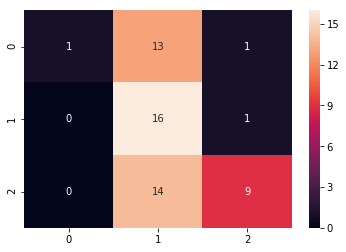

In [1204]:
sns.heatmap(confusion_matrix(df_test['class'], df_test['class_preds']),annot=True )